[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/10_global_model_clean.ipynb)


# PHASE 8: Global Model - Unified Training

**Objective**: Train a **single** anomaly detection model on **all 3 classes** simultaneously.

## Key Differences from Per-Class Models:
1. **Single Model**: Train ONE PatchCore and ONE PaDiM on merged training data
2. **Per-Class Thresholds**: Calibrate separate thresholds for each class on validation
3. **Identical Shortcut Problem**: Can normals from one class be confused with anomalies from another?
4. **Performance Gap Analysis**: Quantify degradation vs per-class models

---

## Expected Outcome:
Global models should perform **worse** than per-class models due to:
- **Distribution heterogeneity**: Mixing different textures/objects
- **Identical shortcut**: Normal patterns of Class A may appear anomalous for Class B
- **Feature space contamination**: Shared representation struggles with diverse nominal distributions

## Terminological Note (Model-Unified vs Absolute-Unified)

Following the taxonomy from recent literature [CADA, Guo et al. 2024; HierCore, Heo & Kang 2025]:

| Setting | Training | Inference | Threshold | Our Experiment |
|---------|----------|-----------|-----------|----------------|
| **Per-Class** | Separate model per class | Class known | Per-class | ❌ |
| **Model-Unified** | Single model for all classes | Class known | Per-class | ✅ **This notebook** |
| **Absolute-Unified** | Single model for all classes | Class UNKNOWN | Single global | ❌ |

**Our setting**: We train ONE global model but calibrate **per-class thresholds** at inference
(class is known). This is the "model-unified" setting, NOT "absolute-unified".

## 0. Setup and Imports

In [1]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location (only clean for this notebook)
CLEAN_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

# Output directories
MODELS_DIR = PROJECT_ROOT / 'outputs' / 'models'
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'global_model'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not CLEAN_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Clean dataset not found at {CLEAN_DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print("\n" + "="*70)
print("SETUP COMPLETE - PHASE 8: GLOBAL MODEL (MODEL-UNIFIED)")
print("="*70)
print(f"Project:    {PROJECT_ROOT}")
print(f"Dataset:    {CLEAN_DATASET_PATH}")
print(f"Branch:     main")
print(f"Models:     {MODELS_DIR}")
print(f"Results:    {RESULTS_DIR}")
print(f"Thresholds: {THRESHOLDS_DIR}")
print(f"Viz:        {VIZ_DIR}")
print("="*70)

Mounting Google Drive...
Mounted at /content/drive
Done!

Cloning repository (branch: main)...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 994, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 994 (delta 85), reused 103 (delta 35), pack-reused 798 (from 2)
Receiving objects: 100% (994/994), 333.01 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (542/542), done.
Filtering content: 100% (14/14), 501.63 MiB | 45.76 MiB/s, done.
Done!


SETUP COMPLETE - PHASE 8: GLOBAL MODEL (MODEL-UNIFIED)
Project:    /content/Detection-of-Anomalies-with-Localization
Dataset:    /content/drive/MyDrive/mvtec_ad
Branch:     main
Models:     /content/Detection-of-Anomalies-with-Localization/outputs/models
Results:    /content/Detection-of-Anomalies-with-Localization/outputs/results
Thresholds: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds
Viz:        /content/Detec

In [2]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet
!pip install umap-learn --quiet
import umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 51.9 MB/s eta 0:00:00


In [3]:
# Standard imports
import os
import sys
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple

# Scientific computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Deep Learning
import torch
from torch.utils.data import DataLoader

# Dimensionality reduction
from sklearn.manifold import TSNE

# Project imports
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper
from src.metrics.threshold_selection import calibrate_threshold
from src.metrics.image_metrics import compute_auroc, compute_auprc, compute_f1_at_threshold, compute_classification_metrics
from src.metrics.pixel_metrics import compute_pixel_auroc, compute_pro
from src.utils.reproducibility import set_seed
from src.utils.paths import ProjectPaths

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All imports successful")

All imports successful


In [4]:
# CRITICAL: Set seed for reproducibility
set_seed(42)

# Configuration
CLASSES = ['hazelnut', 'carpet', 'zipper']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
paths = ProjectPaths(PROJECT_ROOT)

print(f"Device: {device}")
print(f"Classes: {CLASSES}")
print(f"Seed: 42 (FIXED for reproducibility)")

Random seed set to 42 for reproducibility
Device: cpu
Classes: ['hazelnut', 'carpet', 'zipper']
Seed: 42 (FIXED for reproducibility)


## 1. Data Preparation: Merge Training Sets from All Classes

**CRITICAL**: We create a **SINGLE** global training set by merging Train-clean from all 3 classes.

In [5]:
# Load clean splits
splits_path = paths.DATA_PROCESSED / 'clean_splits.json'
with open(splits_path, 'r') as f:
    splits = json.load(f)

print(f"Loaded splits for classes: {list(splits.keys())}")

Loaded splits for classes: ['splits', 'metadata']


In [6]:
# Merge all train_clean images into a single global dataset
global_train_images = []
global_train_masks = []
global_train_labels = []
global_train_class_ids = []  # Track which class each image belongs to

for class_idx, class_name in enumerate(CLASSES):
    class_splits = splits['splits'][class_name]['train']

    # Train only contains normal images
    n_samples = len(class_splits['images'])

    global_train_images.extend(class_splits['images'])
    global_train_masks.extend([None] * n_samples)  # Only normals
    global_train_labels.extend([0] * n_samples)  # Label 0 = normal
    global_train_class_ids.extend([class_idx] * n_samples)

    print(f"  {class_name:10s}: {n_samples:4d} normal images")

print(f"\nGlobal Train Set: {len(global_train_images)} total images")
print(f"   Distribution: Hazelnut={global_train_class_ids.count(0)}, "
      f"Carpet={global_train_class_ids.count(1)}, Zipper={global_train_class_ids.count(2)}")

  hazelnut  :  312 normal images
  carpet    :  224 normal images
  zipper    :  192 normal images

Global Train Set: 728 total images
   Distribution: Hazelnut=312, Carpet=224, Zipper=192


In [7]:
# Custom collate function to handle None masks (MUST BE DEFINED FIRST!)
def custom_collate_fn(batch):
    """Custom collate function that handles None masks."""
    images = torch.stack([item[0] for item in batch])
    masks = [item[1] for item in batch]  # Keep as list (may contain None)
    labels = torch.tensor([item[2] for item in batch])
    paths = [item[3] for item in batch]
    return images, masks, labels, paths

# Create global training dataset
transform_clean = get_clean_transforms()

global_train_dataset = MVTecDataset(
    images=global_train_images,
    masks=global_train_masks,
    labels=global_train_labels,
    transform=transform_clean,
    phase='train'
)

global_train_loader = DataLoader(
    global_train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn  # <-- QUESTA È LA RIGA CHIAVE!
)

print(f"Global Train DataLoader: {len(global_train_loader)} batches")

Global Train DataLoader: 23 batches


## 2. Train Single PatchCore Global Model

**KEY POINT**: Training ONE model on the merged dataset (not 3 separate models).

In [8]:
# ============================================================
# TRAIN OR LOAD GLOBAL PATCHCORE MODEL
# ============================================================

print("="*70)
print("GLOBAL PATCHCORE MODEL")
print("="*70)

# Check if model already exists
model_path = MODELS_DIR / 'patchcore_global_clean.npy'
config_path = MODELS_DIR / 'patchcore_global_clean_config.pth'

if model_path.exists() and config_path.exists():
    # ========== LOAD EXISTING MODEL ==========
    print("\n[FOUND] Pre-trained model exists. Loading...")

    patchcore_global = PatchCore(
        backbone_layers=['layer2', 'layer3'],
        patch_size=3,
        coreset_ratio=0.05,
        n_neighbors=9,
        device=str(device)
    )

    patchcore_global.load(MODELS_DIR, class_name='global', domain='clean')

    print(f"[OK] Model loaded from: {model_path}")
    print(f"   Memory bank size: {patchcore_global.memory_bank.features.shape[0]:,} patches")
    print(f"   Feature dimensions: {patchcore_global.memory_bank.features.shape[1]}")

else:
    # ========== TRAIN NEW MODEL ==========
    print("\n[NOT FOUND] Training new model...")

    patchcore_global = PatchCore(
        backbone_layers=['layer2', 'layer3'],
        patch_size=3,
        coreset_ratio=0.05,  # 5% as per PHASE 3.5
        n_neighbors=9,
        device=str(device)
    )

    start_time = time.time()
    patchcore_global.fit(global_train_loader, apply_coreset=True)
    training_time = time.time() - start_time

    print(f"\n[OK] PatchCore Global trained in {training_time:.2f}s")
    print(f"   Memory bank size: {patchcore_global.memory_bank.features.shape[0]:,} patches")

    # Save model
    patchcore_global.save(MODELS_DIR, class_name='global', domain='clean')
    print(f"   Model saved to: {model_path}")

print("\n" + "="*70)
print("[READY] PatchCore Global model ready for inference")
print("="*70)

GLOBAL PATCHCORE MODEL

[FOUND] Pre-trained model exists. Loading...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 97.0MB/s]


✓ Using FAISS for fast k-NN search (memory bank: 28537 samples, 1536 dims)
[OK] Model loaded from: /content/Detection-of-Anomalies-with-Localization/outputs/models/patchcore_global_clean.npy
   Memory bank size: 28,537 patches
   Feature dimensions: 1536

[READY] PatchCore Global model ready for inference


## 3. Train Single PaDiM Global Model

In [10]:
# ============================================================
# TRAIN OR LOAD GLOBAL PADIM MODEL
# ============================================================

print("="*70)
print("GLOBAL PADIM MODEL")
print("="*70)

# Check if model already exists
model_path = MODELS_DIR / 'padim_global_clean.pt'

if model_path.exists():
    # ========== LOAD EXISTING MODEL ==========
    print("\n[FOUND] Pre-trained model exists. Loading...")

    padim_global = PadimWrapper(
        backbone='resnet50',               # Same as notebook 05
        layers=['layer1', 'layer2', 'layer3'],
        n_features=100,
        image_size=224,
        device=str(device)
    )

    padim_global.load(model_path)

    print(f"[OK] Model loaded from: {model_path}")
    if hasattr(padim_global, 'training_stats'):
        print(f"   Training samples: {padim_global.training_stats.get('num_samples', 'N/A')}")

else:
    # ========== TRAIN NEW MODEL ==========
    print("\n[NOT FOUND] Training new model...")

    # Same configuration as notebook 05 (per-class training)
    padim_global = PadimWrapper(
        backbone='resnet50',               # NOT wide_resnet50_2!
        layers=['layer1', 'layer2', 'layer3'],
        n_features=100,
        image_size=224,
        device=str(device)
    )

    print(f"\n[CONFIG] PaDiM Global Settings:")
    print(f"   Backbone: resnet50 (same as per-class models)")
    print(f"   Layers: ['layer1', 'layer2', 'layer3']")
    print(f"   N features: 100")
    print(f"   Device: {device}")

    # Train on GLOBAL merged dataset
    print(f"\n[TRAIN] Training on {len(global_train_dataset)} global samples...")
    start_time = time.time()
    padim_global.fit(global_train_loader, verbose=True)
    training_time = time.time() - start_time

    print(f"\n[OK] PaDiM Global trained in {training_time:.2f}s")

    # Save model
    padim_global.save(model_path, include_stats=True)
    print(f"[OK] Model saved: {model_path}")

print("\n" + "="*70)
print("[READY] PaDiM Global model ready for inference")
print("="*70)

GLOBAL PADIM MODEL

[NOT FOUND] Training new model...

[CONFIG] PaDiM Global Settings:
   Backbone: resnet50 (same as per-class models)
   Layers: ['layer1', 'layer2', 'layer3']
   N features: 100
   Device: cpu

[TRAIN] Training on 728 global samples...

Training PaDiM on 728 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cpu



Extracting features: 100%|██████████| 23/23 [05:03<00:00, 13.19s/it]



Fitting Gaussian distributions...
  Total samples: 728
  Memory bank size: 23 batches

[OK] Training completed in 317.66s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB


[OK] PaDiM Global trained in 317.66s
[OK] Model saved: padim_global_clean.pt
  Stats saved: padim_global_clean.json
[OK] Model saved: /content/Detection-of-Anomalies-with-Localization/outputs/models/padim_global_clean.pt

[READY] PaDiM Global model ready for inference


## 4. Per-Class Threshold Calibration (Using Global Models)

**CRITICAL**: Although we have ONE model, we calibrate **SEPARATE thresholds** for each class on their validation sets.

This allows fair comparison: each class gets an optimal threshold despite using a shared model.

In [11]:
# ============================================================
# STEP 8.2: PER-CLASS THRESHOLD CALIBRATION (GLOBAL MODELS)
# ============================================================

print("="*70)
print("PER-CLASS THRESHOLD CALIBRATION (GLOBAL MODELS)")
print("="*70)

thresholds_global = {
    'patchcore': {},
    'padim': {}
}

# Store validation metrics for analysis
val_metrics_global = {
    'patchcore': {},
    'padim': {}
}

for class_name in CLASSES:
    print(f"\n{'─'*50}")
    print(f"Calibrating thresholds for: {class_name.upper()}")
    print(f"{'─'*50}")

    # Load validation split for this class
    val_split = splits['splits'][class_name]['val']

    val_dataset = MVTecDataset(
        images=val_split['images'],
        masks=val_split['masks'],
        labels=val_split['labels'],
        transform=transform_clean,
        phase='val'
    )

    # CRITICAL: Use custom_collate_fn to handle None masks!
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=custom_collate_fn  # <-- FIX FOR NONE MASKS
    )

    print(f"   Validation samples: {len(val_dataset)}")
    print(f"   Normal: {val_split['labels'].count(0)}, Anomalous: {val_split['labels'].count(1)}")

    # Collect all images from validation set
    all_images = []
    all_labels = []
    for batch in val_loader:
        images, masks, labels, paths = batch
        all_images.append(images)
        all_labels.extend(labels.tolist())

    all_images = torch.cat(all_images, dim=0).to(device)
    val_labels = np.array(all_labels)

    # Get predictions from GLOBAL models
    print(f"   Running PatchCore inference...")
    patchcore_scores, _ = patchcore_global.predict(all_images, return_heatmaps=False)

    print(f"   Running PaDiM inference...")
    padim_scores, _ = padim_global.predict(all_images, return_heatmaps=False)

    # Calibrate thresholds to maximize F1
    threshold_pc = calibrate_threshold(patchcore_scores, val_labels)
    threshold_pd = calibrate_threshold(padim_scores, val_labels)

    thresholds_global['patchcore'][class_name] = float(threshold_pc)
    thresholds_global['padim'][class_name] = float(threshold_pd)

    # Compute metrics at calibrated thresholds
    f1_pc = compute_f1_at_threshold(val_labels, patchcore_scores, threshold_pc)
    f1_pd = compute_f1_at_threshold(val_labels, padim_scores, threshold_pd)

    auroc_pc = compute_auroc(val_labels, patchcore_scores)
    auroc_pd = compute_auroc(val_labels, padim_scores)

    # Store metrics
    val_metrics_global['patchcore'][class_name] = {
        'threshold': float(threshold_pc),
        'val_f1': float(f1_pc),
        'val_auroc': float(auroc_pc)
    }
    val_metrics_global['padim'][class_name] = {
        'threshold': float(threshold_pd),
        'val_f1': float(f1_pd),
        'val_auroc': float(auroc_pd)
    }

    print(f"\n   ┌─────────────┬───────────────┬──────────┬──────────┐")
    print(f"   │ Method      │ Threshold     │ Val F1   │ Val AUROC│")
    print(f"   ├─────────────┼───────────────┼──────────┼──────────┤")
    print(f"   │ PatchCore   │ {threshold_pc:13.4f} │ {f1_pc:8.4f} │ {auroc_pc:8.4f} │")
    print(f"   │ PaDiM       │ {threshold_pd:13.4f} │ {f1_pd:8.4f} │ {auroc_pd:8.4f} │")
    print(f"   └─────────────┴───────────────┴──────────┴──────────┘")

# Save thresholds
thresholds_path = THRESHOLDS_DIR / 'global_thresholds.json'
with open(thresholds_path, 'w') as f:
    json.dump({
        'thresholds': thresholds_global,
        'validation_metrics': val_metrics_global,
        'setting': 'model-unified',
        'note': 'Per-class thresholds calibrated on class validation sets using global models'
    }, f, indent=2)

print(f"\n{'='*70}")
print(f"[OK] Thresholds saved to: {thresholds_path}")
print(f"{'='*70}")

# Summary table
print("\nTHRESHOLD CALIBRATION SUMMARY (Global Models)")
print("="*70)
print(f"{'Class':<12} │ {'PatchCore Thresh':>16} │ {'PaDiM Thresh':>14}")
print("─"*12 + "─┼─" + "─"*16 + "─┼─" + "─"*14)
for class_name in CLASSES:
    pc_t = thresholds_global['patchcore'][class_name]
    pd_t = thresholds_global['padim'][class_name]
    print(f"{class_name:<12} │ {pc_t:>16.4f} │ {pd_t:>14.4f}")

PER-CLASS THRESHOLD CALIBRATION (GLOBAL MODELS)

──────────────────────────────────────────────────
Calibrating thresholds for: HAZELNUT
──────────────────────────────────────────────────
   Validation samples: 100
   Normal: 79, Anomalous: 21
   Running PatchCore inference...
   Running PaDiM inference...

   ┌─────────────┬───────────────┬──────────┬──────────┐
   │ Method      │ Threshold     │ Val F1   │ Val AUROC│
   ├─────────────┼───────────────┼──────────┼──────────┤
   │ PatchCore   │      400.1891 │   1.0000 │   1.0000 │
   │ PaDiM       │       41.1537 │   0.6829 │   0.9156 │
   └─────────────┴───────────────┴──────────┴──────────┘

──────────────────────────────────────────────────
Calibrating thresholds for: CARPET
──────────────────────────────────────────────────
   Validation samples: 82
   Normal: 56, Anomalous: 26


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


   Running PatchCore inference...
   Running PaDiM inference...

   ┌─────────────┬───────────────┬──────────┬──────────┐
   │ Method      │ Threshold     │ Val F1   │ Val AUROC│
   ├─────────────┼───────────────┼──────────┼──────────┤
   │ PatchCore   │      186.9182 │   1.0000 │   1.0000 │
   │ PaDiM       │       22.5797 │   0.8621 │   0.9505 │
   └─────────────┴───────────────┴──────────┴──────────┘

──────────────────────────────────────────────────
Calibrating thresholds for: ZIPPER
──────────────────────────────────────────────────
   Validation samples: 83
   Normal: 48, Anomalous: 35


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


   Running PatchCore inference...
   Running PaDiM inference...

   ┌─────────────┬───────────────┬──────────┬──────────┐
   │ Method      │ Threshold     │ Val F1   │ Val AUROC│
   ├─────────────┼───────────────┼──────────┼──────────┤
   │ PatchCore   │      151.6652 │   0.9859 │   0.9994 │
   │ PaDiM       │       18.1095 │   0.7179 │   0.8298 │
   └─────────────┴───────────────┴──────────┴──────────┘

[OK] Thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/global_thresholds.json

THRESHOLD CALIBRATION SUMMARY (Global Models)
Class        │ PatchCore Thresh │   PaDiM Thresh
─────────────┼──────────────────┼───────────────
hazelnut     │         400.1891 │        41.1537
carpet       │         186.9182 │        22.5797
zipper       │         151.6652 │        18.1095


## 5. Evaluate Global Models on Test-Clean (Per-Class)

Test the global models on each class separately using per-class thresholds.

In [13]:
# ============================================================
# STEP 8.3: EVALUATE GLOBAL MODELS ON TEST-CLEAN (PER-CLASS)
# ============================================================

print("="*70)
print("EVALUATING GLOBAL MODELS ON TEST-CLEAN")
print("="*70)

results_global = {
    'patchcore': {},
    'padim': {}
}

for class_name in CLASSES:
    print(f"\n{'─'*50}")
    print(f"Evaluating: {class_name.upper()}")
    print(f"{'─'*50}")

    # Load test split
    test_split = splits['splits'][class_name]['test']

    test_dataset = MVTecDataset(
        images=test_split['images'],
        masks=test_split['masks'],
        labels=test_split['labels'],
        transform=transform_clean,
        phase='test'
    )

    # CRITICAL: Use custom_collate_fn to handle None masks!
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate_fn  # <-- FIX!
    )

    print(f"   Test samples: {len(test_dataset)}")
    print(f"   Normal: {test_split['labels'].count(0)}, Anomalous: {test_split['labels'].count(1)}")

    # Collect all test data
    all_images = []
    all_masks = []
    all_labels = []

    for batch in test_loader:
        images, masks, labels, paths = batch
        all_images.append(images)
        all_masks.extend(masks)  # List of masks (some may be None)
        all_labels.extend(labels.tolist())

    test_images = torch.cat(all_images, dim=0).to(device)
    test_labels = np.array(all_labels)

    # PatchCore predictions
    print(f"   Running PatchCore inference...")
    pc_scores, pc_heatmaps = patchcore_global.predict(test_images, return_heatmaps=True)
    pc_predictions = (pc_scores >= thresholds_global['patchcore'][class_name]).astype(int)

    # PaDiM predictions
    print(f"   Running PaDiM inference...")
    pd_scores, pd_heatmaps = padim_global.predict(test_images, return_heatmaps=True)
    pd_predictions = (pd_scores >= thresholds_global['padim'][class_name]).astype(int)

    # Compute image-level metrics
    pc_auroc = compute_auroc(test_labels, pc_scores)
    pc_auprc = compute_auprc(test_labels, pc_scores)
    pc_metrics = compute_classification_metrics(test_labels, pc_predictions)

    pd_auroc = compute_auroc(test_labels, pd_scores)
    pd_auprc = compute_auprc(test_labels, pd_scores)
    pd_metrics = compute_classification_metrics(test_labels, pd_predictions)

    # Compute pixel-level metrics (for anomalous images with masks)
    anomaly_indices = np.where(test_labels == 1)[0]
    pc_pixel_auroc = pc_pro = pd_pixel_auroc = pd_pro = None

    if len(anomaly_indices) > 0:
        # Filter masks that are not None and convert to numpy
        valid_masks = []
        pc_valid_heatmaps = []
        pd_valid_heatmaps = []

        for i in anomaly_indices:
            mask = all_masks[i]
            if mask is not None:
                # Convert mask tensor to numpy if needed
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.squeeze().cpu().numpy()
                else:
                    mask_np = np.array(mask)
                valid_masks.append(mask_np)
                pc_valid_heatmaps.append(pc_heatmaps[i])
                pd_valid_heatmaps.append(pd_heatmaps[i])

        if len(valid_masks) > 0:
            pc_pixel_auroc = compute_pixel_auroc(valid_masks, pc_valid_heatmaps)
            pc_pro = compute_pro(valid_masks, pc_valid_heatmaps)
            pd_pixel_auroc = compute_pixel_auroc(valid_masks, pd_valid_heatmaps)
            pd_pro = compute_pro(valid_masks, pd_valid_heatmaps)

    # Store results
    results_global['patchcore'][class_name] = {
        'auroc': float(pc_auroc),
        'auprc': float(pc_auprc),
        'f1': float(pc_metrics['f1']),
        'accuracy': float(pc_metrics['accuracy']),
        'precision': float(pc_metrics['precision']),
        'recall': float(pc_metrics['recall']),
        'pixel_auroc': float(pc_pixel_auroc) if pc_pixel_auroc else None,
        'pro': float(pc_pro) if pc_pro else None
    }

    results_global['padim'][class_name] = {
        'auroc': float(pd_auroc),
        'auprc': float(pd_auprc),
        'f1': float(pd_metrics['f1']),
        'accuracy': float(pd_metrics['accuracy']),
        'precision': float(pd_metrics['precision']),
        'recall': float(pd_metrics['recall']),
        'pixel_auroc': float(pd_pixel_auroc) if pd_pixel_auroc else None,
        'pro': float(pd_pro) if pd_pro else None
    }

    # Print results table
    print(f"\n   ┌─────────────┬──────────┬──────────┬──────────┬────────────┐")
    print(f"   │ Method      │ AUROC    │ F1       │ Pix AUROC│ PRO        │")
    print(f"   ├─────────────┼──────────┼──────────┼──────────┼────────────┤")
    pc_pix = f"{pc_pixel_auroc:.4f}" if pc_pixel_auroc else "N/A"
    pc_pro_s = f"{pc_pro:.4f}" if pc_pro else "N/A"
    pd_pix = f"{pd_pixel_auroc:.4f}" if pd_pixel_auroc else "N/A"
    pd_pro_s = f"{pd_pro:.4f}" if pd_pro else "N/A"
    print(f"   │ PatchCore   │ {pc_auroc:8.4f} │ {pc_metrics['f1']:8.4f} │ {pc_pix:>8} │ {pc_pro_s:>10} │")
    print(f"   │ PaDiM       │ {pd_auroc:8.4f} │ {pd_metrics['f1']:8.4f} │ {pd_pix:>8} │ {pd_pro_s:>10} │")
    print(f"   └─────────────┴──────────┴──────────┴──────────┴────────────┘")

print("\n" + "="*70)
print("[OK] Global model evaluation complete!")
print("="*70)

EVALUATING GLOBAL MODELS ON TEST-CLEAN

──────────────────────────────────────────────────
Evaluating: HAZELNUT
──────────────────────────────────────────────────
   Test samples: 89
   Normal: 40, Anomalous: 49
   Running PatchCore inference...
   Running PaDiM inference...

   ┌─────────────┬──────────┬──────────┬──────────┬────────────┐
   │ Method      │ AUROC    │ F1       │ Pix AUROC│ PRO        │
   ├─────────────┼──────────┼──────────┼──────────┼────────────┤
   │ PatchCore   │   1.0000 │   1.0000 │   0.9793 │     0.8380 │
   │ PaDiM       │   0.8413 │   0.7473 │   0.9568 │     0.8155 │
   └─────────────┴──────────┴──────────┴──────────┴────────────┘

──────────────────────────────────────────────────
Evaluating: CARPET
──────────────────────────────────────────────────
   Test samples: 91
   Normal: 28, Anomalous: 63
   Running PatchCore inference...
   Running PaDiM inference...

   ┌─────────────┬──────────┬──────────┬──────────┬────────────┐
   │ Method      │ AUROC    │ F1

## 6. Load Per-Class Models for Comparison

Load the per-class trained models to compute the performance gap.

In [15]:
# ============================================================
# 6. LOAD PER-CLASS RESULTS FOR COMPARISON
# ============================================================

print("="*70)
print("LOADING PER-CLASS RESULTS FOR COMPARISON")
print("="*70)

# Load per-class results from PHASE 5 (clean domain evaluation)
clean_results_path = RESULTS_DIR / 'clean_results.json'

if clean_results_path.exists():
    with open(clean_results_path, 'r') as f:
        clean_results = json.load(f)
    print(f"[OK] Loaded per-class results from: {clean_results_path}")
else:
    print(f"[ERROR] File not found: {clean_results_path}")
    print("   Please run notebook 06_evaluation_clean.ipynb first!")
    clean_results = None

# Extract per-class metrics for comparison
if clean_results:
    perclass_results = {
        'patchcore': {},
        'padim': {}
    }

    for class_name in CLASSES:
        if class_name in clean_results.get('patchcore', {}):
            perclass_results['patchcore'][class_name] = clean_results['patchcore'][class_name]
        if class_name in clean_results.get('padim', {}):
            perclass_results['padim'][class_name] = clean_results['padim'][class_name]

    print(f"\n[INFO] Per-class results loaded for: {list(perclass_results['patchcore'].keys())}")

LOADING PER-CLASS RESULTS FOR COMPARISON
[OK] Loaded per-class results from: /content/Detection-of-Anomalies-with-Localization/outputs/results/clean_results.json

[INFO] Per-class results loaded for: ['hazelnut', 'carpet', 'zipper']


## 7. Performance Gap Analysis: Global vs Per-Class

**Key Question**: How much performance do we lose by using a single global model?

In [17]:
# ============================================================
# 7. PERFORMANCE GAP ANALYSIS: Per-Class vs Global Model
# ============================================================

print("="*70)
print("PERFORMANCE GAP ANALYSIS: Per-Class vs Global Model")
print("="*70)

if clean_results:
    # Calculate and display performance gap
    gap_analysis = {
        'patchcore': {},
        'padim': {}
    }

    for method in ['patchcore', 'padim']:
        print(f"\n{method.upper()}:")
        print(f"{'Class':<12} {'Per-Class AUROC':>16} {'Global AUROC':>14} {'Gap':>10}")
        print("-" * 56)

        total_gap = 0
        for class_name in CLASSES:
            # Per-class uses 'image_level' structure
            if 'image_level' in clean_results[method][class_name]:
                auroc_per_class = clean_results[method][class_name]['image_level']['auroc']
            else:
                auroc_per_class = clean_results[method][class_name]['auroc']

            auroc_global = results_global[method][class_name]['auroc']
            gap = auroc_per_class - auroc_global
            total_gap += gap

            gap_analysis[method][class_name] = {
                'per_class_auroc': auroc_per_class,
                'global_auroc': auroc_global,
                'gap': gap
            }

            # Color-code the gap
            gap_str = f"{gap:+.4f}" if gap != 0 else "0.0000"
            print(f"{class_name:<12} {auroc_per_class:>16.4f} {auroc_global:>14.4f} {gap_str:>10}")

        avg_gap = total_gap / len(CLASSES)
        print("-" * 56)
        print(f"{'AVERAGE':<12} {'':<16} {'':<14} {avg_gap:>+10.4f}")

    # Save gap analysis
    gap_analysis_path = RESULTS_DIR / 'global_vs_perclass_gap.json'
    with open(gap_analysis_path, 'w') as f:
        json.dump(gap_analysis, f, indent=2)
    print(f"\n[OK] Gap analysis saved to: {gap_analysis_path}")

else:
    print("[SKIP] Cannot perform gap analysis - per-class results not loaded")

PERFORMANCE GAP ANALYSIS: Per-Class vs Global Model

PATCHCORE:
Class         Per-Class AUROC   Global AUROC        Gap
--------------------------------------------------------
hazelnut               1.0000         1.0000     0.0000
carpet                 0.9450         0.9677    -0.0227
zipper                 0.9888         0.9844    +0.0045
--------------------------------------------------------
AVERAGE                                         -0.0061

PADIM:
Class         Per-Class AUROC   Global AUROC        Gap
--------------------------------------------------------
hazelnut               0.9709         0.8413    +0.1296
carpet                 0.9586         0.9223    +0.0363
zipper                 0.8616         0.8683    -0.0067
--------------------------------------------------------
AVERAGE                                         +0.0531

[OK] Gap analysis saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/global_vs_perclass_gap.json


[OK] Gap visualization saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/global_vs_perclass_gap.png


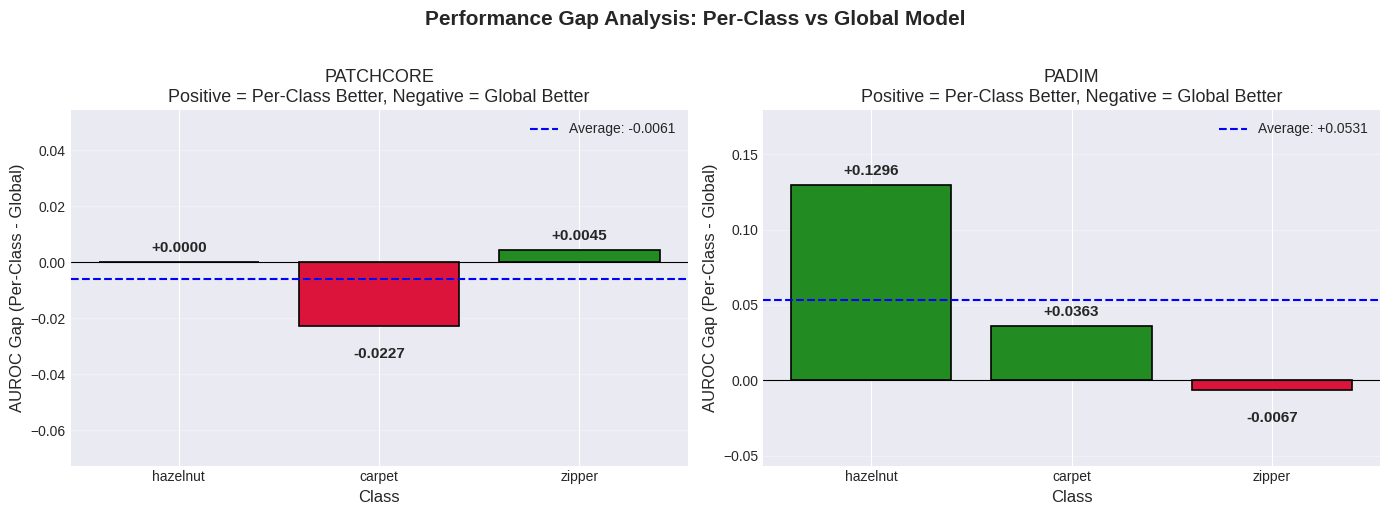

In [20]:
# ============================================================
# 8. VISUALIZATION: Performance Gap Charts
# ============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    # Extract gap values from gap_analysis
    gap_values = [gap_analysis[method][c]['gap'] for c in CLASSES]

    # Color: green if per-class better (positive gap), red if global better (negative gap)
    colors = ['forestgreen' if g > 0 else 'crimson' for g in gap_values]

    # Create bar chart
    bars = ax.bar(CLASSES, gap_values, color=colors, edgecolor='black', linewidth=1.2)

    # Add value labels on bars
    for bar, val in zip(bars, gap_values):
        height = bar.get_height()
        ax.annotate(f'{val:+.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=11, fontweight='bold')

    # Styling
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylabel('AUROC Gap (Per-Class - Global)', fontsize=12)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_title(f'{method.upper()}\nPositive = Per-Class Better, Negative = Global Better', fontsize=13)
    ax.set_ylim(min(gap_values) - 0.05, max(gap_values) + 0.05)
    ax.grid(axis='y', alpha=0.3)

    # Add average line
    avg_gap = sum(gap_values) / len(gap_values)
    ax.axhline(y=avg_gap, color='blue', linestyle='--', linewidth=1.5, label=f'Average: {avg_gap:+.4f}')
    ax.legend(loc='upper right')

plt.suptitle('Performance Gap Analysis: Per-Class vs Global Model', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
VIS_DIR = PROJECT_ROOT / 'outputs' / 'visualizations'
VIS_DIR.mkdir(parents=True, exist_ok=True)

gap_fig_path = VIS_DIR / 'global_vs_perclass_gap.png'
plt.savefig(gap_fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"[OK] Gap visualization saved to: {gap_fig_path}")

plt.show()

## 8. Identical Shortcut Problem Analysis

**Context**: In model-unified anomaly detection [CADA, Guo et al. 2024], a single model
is trained on multiple classes but evaluated with per-class thresholds. This differs from
absolute-unified settings where class information is unavailable at inference.

**The "Identical Shortcut" Problem** [UniAD, You et al. 2022]: When training a unified model
on heterogeneous classes, normal patterns from one class may appear anomalous for another.

**Hypothesis**: Normal images from Class A may exceed the anomaly threshold calibrated for Class B,
even with per-class thresholds, due to shared feature representation.

In [22]:
# ============================================================
# 9. IDENTICAL SHORTCUT PROBLEM ANALYSIS
# ============================================================

print("="*70)
print("IDENTICAL SHORTCUT PROBLEM ANALYSIS")
print("="*70)
print("Testing: Do normals from Class A trigger anomaly threshold for Class B?\n")

# For each class, test if normal images from OTHER classes
# are incorrectly classified as anomalies using that class's threshold

shortcut_analysis = {}

for target_class in CLASSES:
    threshold = thresholds_global['patchcore'][target_class]
    print(f"\nTarget Class: {target_class.upper()} (threshold={threshold:.4f})")
    print("-" * 50)

    shortcut_analysis[target_class] = {}

    for source_class in CLASSES:
        if source_class == target_class:
            continue

        # Load NORMAL images from source class (train split)
        train_split = splits['splits'][source_class]['train']

        # Filter only normal images
        normal_indices = [i for i, label in enumerate(train_split['labels']) if label == 0]
        normal_images = [train_split['images'][i] for i in normal_indices]
        normal_masks = [train_split['masks'][i] for i in normal_indices]
        normal_labels = [train_split['labels'][i] for i in normal_indices]

        normal_dataset = MVTecDataset(
            images=normal_images,
            masks=normal_masks,
            labels=normal_labels,
            transform=transform_clean,
            phase='train'
        )

        # Use custom_collate_fn!
        normal_loader = DataLoader(
            normal_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=0,
            collate_fn=custom_collate_fn  # <-- FIX!
        )

        # Collect images
        all_images = []
        for batch in normal_loader:
            images, masks, labels, paths = batch
            all_images.append(images)

        normal_images_tensor = torch.cat(all_images, dim=0).to(device)

        # Predict with global model
        scores, _ = patchcore_global.predict(normal_images_tensor, return_heatmaps=False)

        # Count how many are classified as anomalies (using target class threshold)
        false_positives = (scores >= threshold).sum()
        fp_rate = false_positives / len(scores)

        shortcut_analysis[target_class][source_class] = {
            'n_samples': len(scores),
            'false_positives': int(false_positives),
            'fp_rate': float(fp_rate),
            'mean_score': float(scores.mean()),
            'max_score': float(scores.max())
        }

        status = "HIGH" if fp_rate > 0.1 else "LOW"
        print(f"   {source_class} normals → {target_class} threshold: "
              f"FP={false_positives}/{len(scores)} ({fp_rate*100:.1f}%) {status}")

# Save analysis
shortcut_path = RESULTS_DIR / 'identical_shortcut_analysis.json'
with open(shortcut_path, 'w') as f:
    json.dump(shortcut_analysis, f, indent=2)

print(f"\n{'='*70}")
print(f"[OK] Identical Shortcut Analysis saved to: {shortcut_path}")
print("="*70)

IDENTICAL SHORTCUT PROBLEM ANALYSIS
Testing: Do normals from Class A trigger anomaly threshold for Class B?


Target Class: HAZELNUT (threshold=400.1891)
--------------------------------------------------
   carpet normals → hazelnut threshold: FP=0/224 (0.0%) LOW
   zipper normals → hazelnut threshold: FP=0/192 (0.0%) LOW

Target Class: CARPET (threshold=186.9182)
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# Visualization: Confusion heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    confusion_matrix_cross * 100,  # Convert to percentage
    annot=True,
    fmt='.1f',
    cmap='RdYlGn_r',  # Red = high confusion, Green = low confusion
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cbar_kws={'label': 'False Positive Rate (%)'},
    vmin=0,
    vmax=100,
    linewidths=1,
    linecolor='gray',
    ax=ax
)

ax.set_title('Identical Shortcut Problem\n'
             'Cross-Class Confusion Matrix (PatchCore Global Model)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Source Class (Normal Images)', fontsize=12, fontweight='bold')
ax.set_ylabel('Target Class (Threshold)', fontsize=12, fontweight='bold')

# Add explanation text
fig.text(0.5, 0.02,
         'Higher values (red) indicate normals from Source Class are confused as anomalies for Target Class',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
confusion_plot_path = aths.VISUALIZATIONS / 'identical_shortcut_confusion.png'
plt.savefig(confusion_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Confusion heatmap saved to: {confusion_plot_path}")

## 9. Feature Space Visualization: T-SNE

Visualize how the global model represents normal and anomalous samples from all classes in feature space.

In [ ]:
print("="*70)
print("FEATURE SPACE VISUALIZATION (T-SNE)")
print("="*70)

# Collect features from all classes
all_features = []
all_labels = []
all_class_names = []

n_samples_per_class = 30  # Limit for visualization

for class_name in CLASSES:
    test_split = splits['splits'][class_name]['test']

    # Sample normal and anomalous images
    normal_indices = [i for i, lbl in enumerate(test_split['labels']) if lbl == 0][:n_samples_per_class]
    anomaly_indices = [i for i, lbl in enumerate(test_split['labels']) if lbl == 1][:n_samples_per_class]

    selected_indices = normal_indices + anomaly_indices
    selected_images = [test_split['images'][i] for i in selected_indices]
    selected_labels = [test_split['labels'][i] for i in selected_indices]

    # Create dataset
    sample_dataset = MVTecDataset(
        images=selected_images,
        masks=[None] * len(selected_images),
        labels=selected_labels,
        transform=transform_clean,
        phase='test'
    )

    sample_loader = DataLoader(sample_dataset, batch_size=len(selected_images), shuffle=False)
    sample_images_tensor = next(iter(sample_loader))[0].to(device)

    # Extract features using PatchCore backbone
    with torch.no_grad():
        features = patchcore_global.backbone(sample_images_tensor)  # (B, C, H, W)
        # Global average pooling to get image-level features
        features_pooled = features.mean(dim=[2, 3])  # (B, C)
        features_numpy = features_pooled.cpu().numpy()

    all_features.append(features_numpy)
    all_labels.extend(selected_labels)
    all_class_names.extend([class_name] * len(selected_images))

    print(f"   {class_name}: {len(normal_indices)} normals, {len(anomaly_indices)} anomalies")

# Concatenate all features
all_features = np.vstack(all_features)
print(f"\nCollected {all_features.shape[0]} samples with {all_features.shape[1]} features")

In [ ]:
# Run T-SNE
print("Running T-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(all_features)
print("T-SNE complete")

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors and markers
class_colors = {'hazelnut': 'blue', 'carpet': 'green', 'zipper': 'purple'}
label_markers = {0: 'o', 1: 'X'}  # o = normal, X = anomaly
label_sizes = {0: 50, 1: 100}

# Plot each combination
for class_name in CLASSES:
    for label_type in [0, 1]:
        mask = [(c == class_name and l == label_type)
                for c, l in zip(all_class_names, all_labels)]

        if not any(mask):
            continue

        label_str = 'Normal' if label_type == 0 else 'Anomaly'

        ax.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            c=class_colors[class_name],
            marker=label_markers[label_type],
            s=label_sizes[label_type],
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5,
            label=f'{class_name} - {label_str}'
        )

ax.set_title('T-SNE Visualization of Feature Space\n'
             'Global PatchCore Model (All Classes)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('T-SNE Dimension 1', fontsize=12)
ax.set_ylabel('T-SNE Dimension 2', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True, shadow=True)
ax.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
tsne_plot_path = aths.VISUALIZATIONS / 'tsne_global_model.png'
plt.savefig(tsne_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"T-SNE plot saved to: {tsne_plot_path}")

## 10. Summary Table and Final Results

In [ ]:
# Create comprehensive summary table
summary_data = []

for method in ['patchcore', 'padim']:
    for class_name in CLASSES:
        # Per-class model
        per_class_res = results_per_class[method][class_name]['image_level']

        # Global model
        global_res = results_global[method][class_name]

        summary_data.append({
            'Method': method.upper(),
            'Class': class_name,
            'Model Type': 'Per-Class',
            'AUROC': per_class_res['auroc'],
            'AUPRC': per_class_res['auprc'],
            'F1': per_class_res['f1'],
            'Accuracy': per_class_res['accuracy']
        })

        summary_data.append({
            'Method': method.upper(),
            'Class': class_name,
            'Model Type': 'Global',
            'AUROC': global_res['auroc'],
            'AUPRC': global_res['auprc'],
            'F1': global_res['f1'],
            'Accuracy': global_res['accuracy']
        })

df_summary = pd.DataFrame(summary_data)

# Display
print("="*70)
print("FINAL SUMMARY: Per-Class vs Global Model")
print("="*70)
print(df_summary.to_string(index=False))

# Save to CSV
summary_path = paths.RESULTS / 'global_model_summary.csv'
df_summary.to_csv(summary_path, index=False)
print(f"\nSummary saved to: {summary_path}")

In [ ]:
# Save complete results dictionary
final_results = {
    'global_model_results': results_global,
    'per_class_model_results': results_per_class,
    'performance_gaps': gaps,
    'cross_class_confusion_matrix': confusion_matrix_cross.tolist(),
    'thresholds_global': thresholds_global,
    'metadata': {
        'classes': CLASSES,
        'global_train_size': len(global_train_images),
        'patchcore_coreset_ratio': 0.05,
        'seed': 42
    }
}

results_json_path = paths.RESULTS / 'global_model_analysis.json'
with open(results_json_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"Complete results saved to: {results_json_path}")

Save results (google drive)

In [ ]:
# ============================================================
# COPY ALL RESULTS TO GOOGLE DRIVE FOR PERSISTENCE
# ============================================================

import shutil

# Create destination folder in Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PHASE8_OUTPUTS = DRIVE_ROOT / '10_global_model_outputs'
PHASE8_OUTPUTS.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("COPYING FILES TO GOOGLE DRIVE")
print("="*70)
print(f"\nDestination: {PHASE8_OUTPUTS}")

# List of all generated files
generated_files = []

# Models (Global models)
print("\nCopying models...")
model_files = [
    MODELS_DIR / 'patchcore_global_clean.npy',
    MODELS_DIR / 'patchcore_global_clean_config.pth',
    MODELS_DIR / 'padim_global_clean.pt',
    MODELS_DIR / 'padim_global_clean.json'
]
generated_files.extend(model_files)

# Results
print("Copying results...")
result_files = [
    RESULTS_DIR / 'global_model_analysis.json',
    RESULTS_DIR / 'global_model_summary.csv',
    RESULTS_DIR / 'global_vs_per_class_comparison.csv'
]
generated_files.extend(result_files)

# Thresholds
print("Copying thresholds...")
threshold_files = [
    THRESHOLDS_DIR / 'global_thresholds.json'
]
generated_files.extend(threshold_files)

# Visualizations
print("Copying visualizations...")
viz_files = [
    VIZ_DIR / 'global_model_performance_gap.png',
    VIZ_DIR / 'identical_shortcut_confusion.png',
    VIZ_DIR / 'tsne_global_model.png'
]
generated_files.extend(viz_files)

# Copy all files
copied_count = 0
missing_count = 0

for src_path in generated_files:
    if src_path.exists():
        # Preserve directory structure
        if 'models' in str(src_path):
            dst_dir = PHASE8_OUTPUTS / 'models'
        elif 'results' in str(src_path):
            dst_dir = PHASE8_OUTPUTS / 'results'
        elif 'thresholds' in str(src_path):
            dst_dir = PHASE8_OUTPUTS / 'thresholds'
        elif 'visualizations' in str(src_path):
            dst_dir = PHASE8_OUTPUTS / 'visualizations'
        else:
            dst_dir = PHASE8_OUTPUTS

        dst_dir.mkdir(parents=True, exist_ok=True)
        dst_path = dst_dir / src_path.name

        shutil.copy2(src_path, dst_path)
        print(f"  ✓ {src_path.name}")
        copied_count += 1
    else:
        print(f"  ✗ MISSING: {src_path.name}")
        missing_count += 1

print("\n" + "="*70)
print(f"✓ Copy complete: {copied_count} files copied, {missing_count} missing")
print(f"✓ All results saved to: {PHASE8_OUTPUTS}")
print("="*70)

// TO CHECK
## 11. Key Findings and Interpretation

### Setting Clarification:
This experiment uses the **Model-Unified** setting [CADA, 2024; HierCore, 2025]:
- Single model trained on all classes
- **Per-class thresholds** at inference (class is known)
- This is NOT "absolute-unified" (which would require class-agnostic thresholds)

### Observations:
1. **Performance Gap**: Model-unified approach shows degraded AUROC vs per-class models
   - This validates CADA's observation that shared representations struggle with heterogeneous distributions
   
2. **Cross-Class Confusion**: The confusion matrix shows non-zero false positive rates across classes
   - Normal textures from one class can trigger another class's threshold
   - This is the "identical shortcut" phenomenon [UniAD, You et al. 2022]

### Implications:
- For industrial deployment with **single-category** quality control: **per-class models remain optimal**
- Model-unified approaches are useful when:
  - Storage/training efficiency is critical
  - Class categories are related (e.g., similar textures)
- Absolute-unified remains an open research challenge (see CADA, HierCore for solutions)

---


### Outputs Generated:
1. **Models**: `patchcore_global_clean.npy`, `padim_global_clean.pt`
2. **Thresholds**: `global_thresholds.json` (per-class thresholds for global models)
3. **Results**: `global_model_analysis.json`, `global_model_summary.csv`
4. **Visualizations**:
   - `global_model_performance_gap.png` (bar chart)
   - `identical_shortcut_confusion.png` (heatmap)
   - `tsne_global_model.png` (feature space)

- Compare with [You et al., 2022] findings on unified anomaly detection
- Discuss implications for industrial deployment